# Word probability and joke length

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load direct and inverted indices
import sys
if '..' not in sys.path:
    sys.path.append('..')
from src.utils import LoadIndices, LoadDatasets, Beep

# Load datasets
an_jokes, bash_jokes = LoadDatasets()
# Load direct and inverted indices
an_direct, an_inverted, bash_direct, bash_inverted = LoadIndices()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's sort jokes according to their length (number of words). Consider cumulative distribution function of word occurences over index in this sorted list. Such functions typically lie between two cases: 
1. probability is proportional to joke length (may be typical for general use words which can be found in any context).
2. probability do not depend on length at all (may be typical for words strongly correlated to some topic)

Figures below shows ideal functions: proportional to length and independant of length.

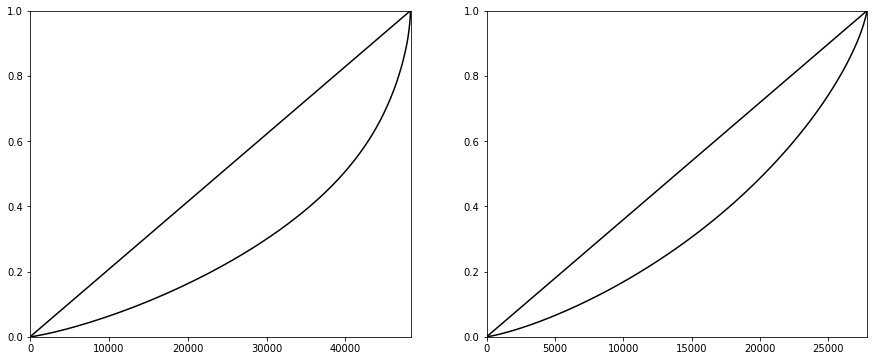

In [28]:
def sort_by_length(direct_index):
    lengths = np.array([sum(d.values()) for d in direct_index])
    idx = np.argsort(lengths)
    return idx, lengths[idx]

def show_ideal_graphs(direct_index):
    num_of_jokes = len(direct_index)
    idx, lengths = sort_by_length(direct_index)
    P = np.zeros(len(lengths) + 1)
    P[1:] = np.cumsum(lengths)
    P = P / P[-1]

    plt.plot(np.arange(num_of_jokes + 1), P, c = 'black')
    plt.plot([0, num_of_jokes], [0, 1], c = 'black')
    plt.xlim(0, num_of_jokes)
    plt.ylim(0, 1)
    
    return idx

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
an_idx = show_ideal_graphs(an_direct)
plt.subplot(1, 2, 2)
bash_idx = show_ideal_graphs(bash_direct)


In [3]:
def invert(idx):
    inv_idx = np.zeros(len(idx), dtype = 'int')
    inv_idx[idx] = np.arange(len(idx))
    return inv_idx

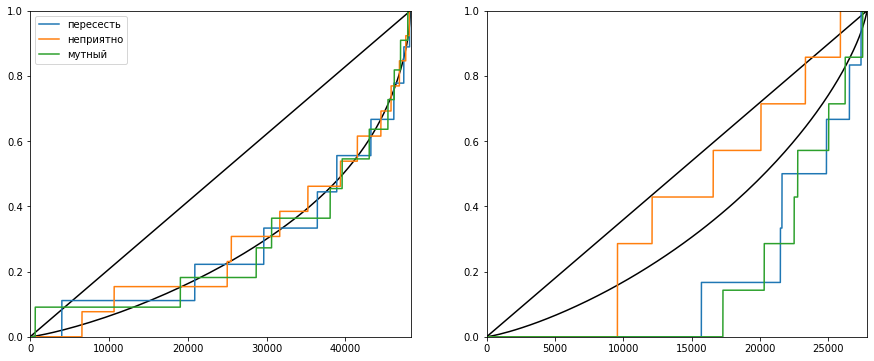

In [44]:
def cum_distrib(word, direct_index, inverted_index, inv_idx):
    y = np.zeros(len(direct_index) + 1)
    if word in inverted_index:
        for i in inverted_index[word][0] + inverted_index[word][1]:
            y[inv_idx[i]] = direct_index[i][word]
        y = np.cumsum(y)
        y /= y[-1]
    return y
        
def show_word_distributions(words):
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    an_idx = show_ideal_graphs(an_direct)
    an_inv_idx = invert(an_idx)
    for word in words: 
        y = cum_distrib(word, an_direct, an_inverted, an_inv_idx)
        plt.plot(range(len(an_direct)+1), y, label = word)
    plt.legend()

    plt.subplot(1, 2, 2)
    bash_idx = show_ideal_graphs(bash_direct)
    bash_inv_idx = invert(bash_idx)
    for word in words: 
        y = cum_distrib(word, bash_direct, bash_inverted, bash_inv_idx)
        plt.plot(range(len(bash_direct)+1), y)
        
    
show_word_distributions(['пересесть', 'неприятно', 'мутный'])

    
    
    
    


## Kolmogorov - Smirnov test

Difference between ideal and real distributions can be measured with K-S test.

$$\sqrt{n}\cdot \sup(|F-F_0|) + \frac{1}{6\sqrt{n}}>K_{\alpha}$$

Here $n$ - number of word use, $F$ - word distribution, $F_0$ - ideal distribution, $K_{\alpha}$ - significance threshold ($K_{0.05}\approx 1.36$, $K_{0.01}\approx 1.63$).

In addition to absolute difference we can also measure positive and negative difference:

$$\sup(F-F_0),\\
\sup(F_0-F)$$


In [22]:
%%time
# ~20 sec expected

def sort_ks_as_dataframe(a, ascending = False):
    df = pd.DataFrame(a, columns = ['word', 'K-S'])
    df = df.sort_values(by = 'K-S', ascending = ascending).reset_index(drop = True)
    return df

def KS_statistics(direct_index, inverted_index):
    length_independent_words = []
    length_proportional_words = []
    not_length_proportional_positive = []
    not_length_proportional_negative = []
    N_jokes = len(direct_index)
    # Sort jokes according their length
    lengths = np.array([sum(d.values()) for d in direct_index])
    idx = np.argsort(lengths)
    lengths = lengths[idx]
    inv_idx = invert(idx)
    # Ideal distribution where word probability is proportional to joke length
    F0 = np.zeros(N_jokes + 1)
    F0[1:] = np.cumsum(lengths)
    F0 /= F0[-1]
    #Ideal distribution of length-independant words
    F0_2 = np.linspace(0, 1, N_jokes + 1)
    # Actual words distributions
    for word in inverted_index:
        if max(len(inverted_index[word][0]), len(inverted_index[word][1])) > 1:
            # Distribution for word
            F = np.zeros(N_jokes + 1)
            for i in inverted_index[word][0] + inverted_index[word][1]:
                F[inv_idx[i]] = direct_index[i][word]
            F = np.cumsum(F)
            n = F[-1]
            F /= n
            # K-S statistics
            sn = np.sqrt(n)
            bolshev_mod = 1 / (6 * sn)
            D_abs = sn * np.max(np.abs(F - F0)) + bolshev_mod
            D_pos = sn * np.max(F - F0) + bolshev_mod
            D_neg = sn * np.max(F0 - F) + bolshev_mod
            D_abs_2 = sn * np.max(np.abs(F - F0_2)) + bolshev_mod
            # Choice of words
            critical_value = 1.36
            if D_abs_2 < critical_value:
                length_independent_words.append((word, D_abs_2))
            if D_abs < critical_value:
                length_proportional_words.append((word, D_abs))
            if D_pos > critical_value:
                not_length_proportional_positive.append((word, D_pos))
            if D_neg > critical_value:
                not_length_proportional_negative.append((word, D_neg))
    liw = sort_ks_as_dataframe(length_independent_words, ascending = True)
    lpw = sort_ks_as_dataframe(length_proportional_words, ascending = True)
    nlpp = sort_ks_as_dataframe(not_length_proportional_positive)
    nlpn = sort_ks_as_dataframe(not_length_proportional_negative)
    return liw, lpw, nlpp, nlpn


an_liw, an_lpw, an_nlpp, an_nlpn = KS_statistics(an_direct, an_inverted)
bash_liw, bash_lpw, bash_nlpp, bash_nlpn = KS_statistics(bash_direct, bash_inverted)



Beep()


Wall time: 17.3 s


In [41]:
from IPython.display import display, HTML
display(HTML(an_lpw[:100].to_html()))

,word,K-S
0,пересесть,0.329120
1,неприятно,0.352421
2,мутный,0.372477
3,дружественный,0.377538
4,прорываться,0.380471
5,церковный,0.385596
6,36,0.391293
7,целостность,0.396068
8,вскидывать,0.398676
9,1.5,0.405307


In [45]:
print(an_lpw[:10])

            word       K-S
0      пересесть  0.329120
1      неприятно  0.352421
2         мутный  0.372477
3  дружественный  0.377538
4    прорываться  0.380471
5      церковный  0.385596
6             36  0.391293
7    целостность  0.396068
8     вскидывать  0.398676
9            1.5  0.405307
